In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import openpyxl
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load data
data = pd.read_csv("/content/Amazon Sale Report.csv", encoding='utf-8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Income              128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [ ]:
#CLeaning missing values or null values
data.dropna(inplace=True)
data['Income'].fillna(0, inplace=True)
print(data.head(10))

    index             Order ID        Date                        Status  \
1       1  171-9198151-1101146  30-04-2022  Shipped - Delivered to Buyer   
7       7  406-7807733-3785945  30-04-2022  Shipped - Delivered to Buyer   
12     12  405-5513694-8146768  30-04-2022  Shipped - Delivered to Buyer   
14     14  408-1298370-1920302  30-04-2022  Shipped - Delivered to Buyer   
15     15  403-4965581-9520319  30-04-2022  Shipped - Delivered to Buyer   
18     18  402-4030358-5835511  30-04-2022  Shipped - Delivered to Buyer   
25     25  405-8191138-5176316  30-04-2022  Shipped - Delivered to Buyer   
26     26  403-9230474-9657916  30-04-2022  Shipped - Delivered to Buyer   
32     32  404-9632124-1107550  30-04-2022  Shipped - Delivered to Buyer   
33     33  402-1465437-0579556  30-04-2022  Shipped - Delivered to Buyer   

   Fulfilment Sales Channel  ship-service-level     Style              SKU  \
1    Merchant      Amazon.in           Standard   JNE3781  JNE3781-KR-XXXL   
7    Me

<ipython-input-5-61dc0695677c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Income'].fillna(0, inplace=True)


In [ ]:
numerical_cols = data.select_dtypes(include=["int64","float64"])
numerical_cols.columns
numerical_cols.describe()

,index,Income,Amount,ship-postal-code,Qty,Groceries,Fruits,Meat Products,Household,Sweet items,Decor
count,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000
mean,60956.478160,44976.504831,650.522920,462097.701096,1.004846,500.039543,125.671400,100.805711,199.223152,50.398642,25.517240
std,36843.686311,14390.096466,284.913465,194276.943115,0.085035,288.045044,72.326225,57.688512,115.436009,28.844502,14.407192
min,1.000000,20004.000000,0.000000,110001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,27188.500000,32686.000000,459.000000,370001.000000,1.000000,251.000000,63.000000,51.000000,99.000000,25.000000,13.000000
50%,63461.000000,45017.000000,631.000000,500017.000000,1.000000,501.000000,125.000000,101.000000,199.000000,50.000000,26.000000
75%,91761.500000,57392.500000,771.000000,600037.000000,1.000000,749.000000,189.000000,150.000000,299.000000,75.000000,38.000000
max,128891.000000,70000.000000,5495.000000,855115.000000,5.000000,1000.000000,250.000000,200.000000,400.000000,100.000000,50.000000


In [ ]:
#Finding credit points for each user
columns_to_average = ['Groceries', 'Fruits', 'Meat Products', 'Household', 'Sweet items']
data_selected = data[columns_to_average]

# Ensure that the columns are numeric
data_selected = data_selected.apply(pd.to_numeric, errors='coerce')

#Assigning weights for every column
weights = {
    'Groceries': 1.5,
    'Fruits': 1,
    'Meat Products': 1.5,
    'Household': 2.5,
    'Sweet items': 2
}
weight_series = pd.Series(weights)

Credit_Points = (data_selected * weight_series).sum(axis=1) / weight_series.sum()

data['Credit_Points'] = Credit_Points

# Display the weighted mean
print("Data with Weighted Mean:")
print(data.head())

Data with Weighted Mean:
    index             Order ID        Date                        Status  \
1       1  171-9198151-1101146  30-04-2022  Shipped - Delivered to Buyer   
7       7  406-7807733-3785945  30-04-2022  Shipped - Delivered to Buyer   
12     12  405-5513694-8146768  30-04-2022  Shipped - Delivered to Buyer   
14     14  408-1298370-1920302  30-04-2022  Shipped - Delivered to Buyer   
15     15  403-4965581-9520319  30-04-2022  Shipped - Delivered to Buyer   

   Fulfilment Sales Channel  ship-service-level     Style              SKU  \
1    Merchant      Amazon.in           Standard   JNE3781  JNE3781-KR-XXXL   
7    Merchant      Amazon.in           Standard   JNE3405     JNE3405-KR-S   
12   Merchant      Amazon.in           Standard   JNE3405    JNE3405-KR-XS   
14   Merchant      Amazon.in           Standard     J0351      J0351-SET-L   
15   Merchant      Amazon.in           Standard  PJNE3368  PJNE3368-KR-6XL   

   Category  ...    B2B fulfilled-by Qty  Groceri

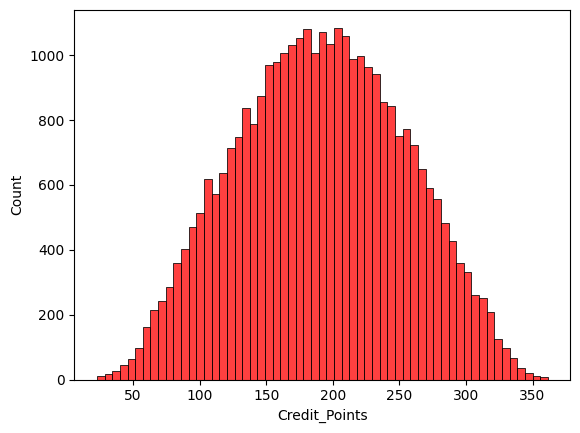

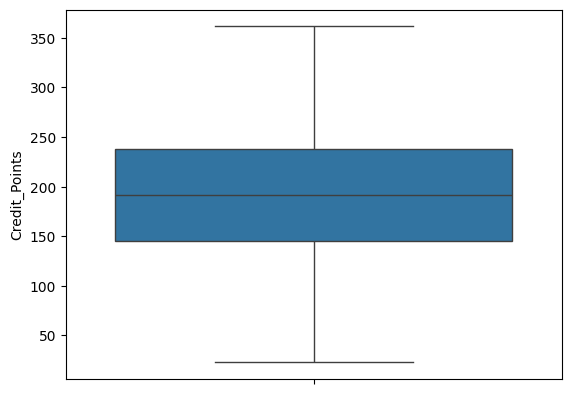

Skewness:  0.000485666389409018


In [ ]:
# Save the histogram to a temporary location
sns.histplot(data['Credit_Points'], color='r')
plt.savefig("CLV_histogram.png", format='png')
plt.show()

# Save the boxplot to a temporary location
sns.boxplot(data['Credit_Points'])
plt.savefig("CLV_boxplot.png", format='png')
plt.show()

# Calculate skewness
skewness = data['Credit_Points'].skew()
print("Skewness: ", skewness)

<ipython-input-24-ff18c929c723>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['Income'],y=data['Credit_Points'], palette='Set1')


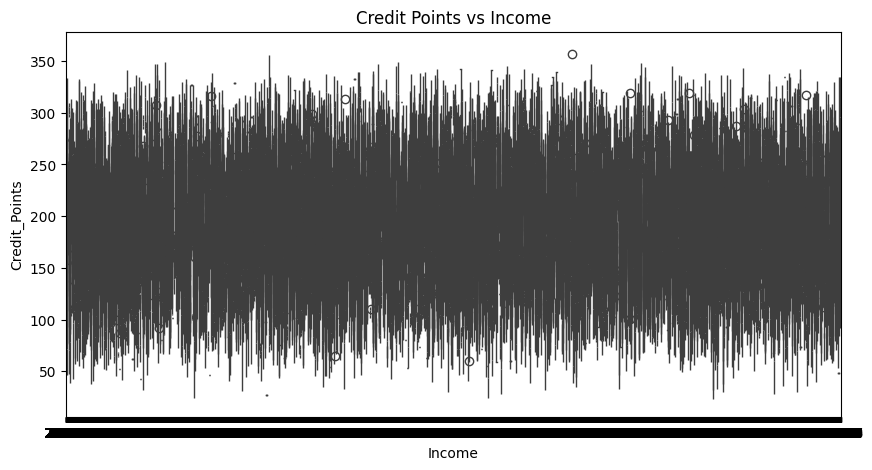

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x=data['Income'],y=data['Credit_Points'], palette='Set1')
plt.title("Credit Points vs Income")
plt.savefig("CLV_line_graph.png", format='png')
plt.show()

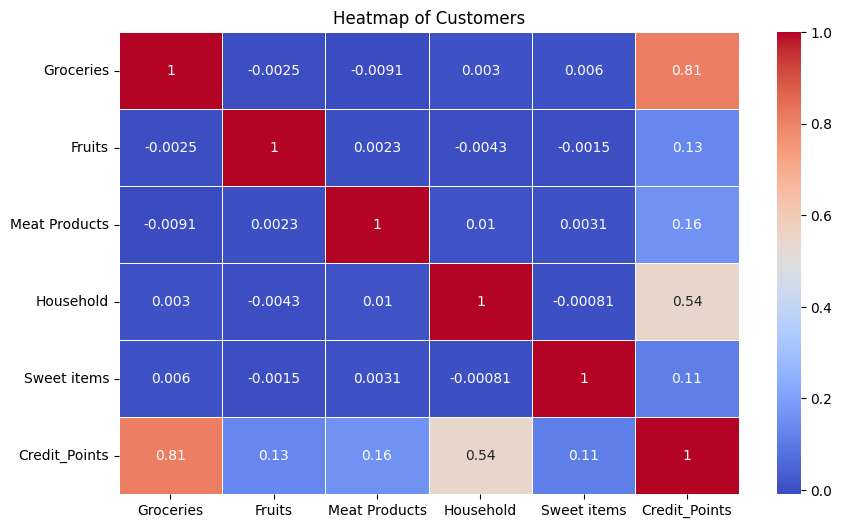

In [ ]:
#Heatmap
columns_for_heatmap = ['Groceries', 'Fruits', 'Meat Products', 'Household', 'Sweet items', 'Credit_Points']

# Select the data for the specified columns
data_subset = data[columns_for_heatmap]

# Create a heatmap
plt.figure(figsize=(10, 6))  # Adjust the size of the heatmap
sns.heatmap(data_subset.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.savefig("CLV_Heatmap.png", format='png')

# Display the heatmap
plt.title('Heatmap of Customers')
plt.show()

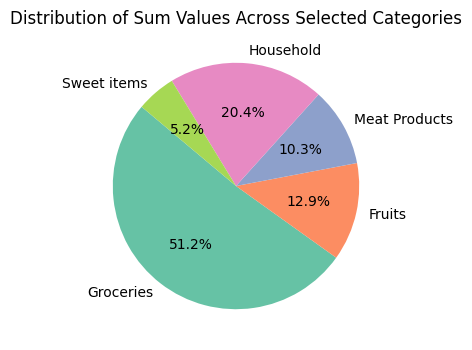

In [ ]:
#Pie chart creation
columns_for_pie = ['Groceries', 'Fruits', 'Meat Products', 'Household', 'Sweet items']

# Sum the values in each column
sums = data[columns_for_pie].sum()

# Create a pie chart
plt.figure(figsize=(6, 4))
plt.pie(sums, labels=columns_for_pie, autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=140)
plt.savefig("CLV_Piechart.png", format='png')

# Add a title
plt.title('Distribution of Sum Values Across Selected Categories')

# Display the pie chart
plt.show()

In [ ]:
#Outlier Detection
z_score = np.abs(stats.zscore(data['Credit_Points']))
print(z_score)

outliers = data[np.abs(z_score) > 1]

# Check if any outliers are found
if outliers.empty:
    print("No outliers found")
else:
    print("Outliers found:")
    print(outliers)

median_value = data['Credit_Points'].median()
data.loc[outliers, 'Credit_Points'] = median_value

1         0.311585
7         0.147028
12        1.735826
14        0.072471
15        0.014395
            ...   
128872    0.004120
128873    0.603004
128874    0.171313
128887    0.171313
128891    1.043704
Name: Credit_Points, Length: 32395, dtype: float64
Outliers found:
         index             Order ID        Date                        Status  \
12          12  405-5513694-8146768  30-04-2022  Shipped - Delivered to Buyer   
26          26  403-9230474-9657916  30-04-2022  Shipped - Delivered to Buyer   
33          33  402-1465437-0579556  30-04-2022  Shipped - Delivered to Buyer   
49          49  171-9208368-0157156  30-04-2022  Shipped - Delivered to Buyer   
60          60  171-2592464-6846743  30-04-2022  Shipped - Delivered to Buyer   
...        ...                  ...         ...                           ...   
128804  128804  408-9579839-6574765  06-01-2022  Shipped - Delivered to Buyer   
128827  128827  408-0422987-5647551  06-01-2022  Shipped - Delivered to Buye

KeyError: "None of [Index([                                                                 ('i', 'n', 'd', 'e', 'x'),\n                                                         ('O', 'r', 'd', 'e', 'r', ' ', 'I', 'D'),\n                                                                             ('D', 'a', 't', 'e'),\n                                                                   ('S', 't', 'a', 't', 'u', 's'),\n                                               ('F', 'u', 'l', 'f', 'i', 'l', 'm', 'e', 'n', 't'),\n                           ('S', 'a', 'l', 'e', 's', ' ', 'C', 'h', 'a', 'n', 'n', 'e', 'l', ' '),\n       ('s', 'h', 'i', 'p', '-', 's', 'e', 'r', 'v', 'i', 'c', 'e', '-', 'l', 'e', 'v', 'e', 'l'),\n                                                                        ('S', 't', 'y', 'l', 'e'),\n                                                                                  ('S', 'K', 'U'),\n                                                         ('C', 'a', 't', 'e', 'g', 'o', 'r', 'y'),\n                                                                             ('S', 'i', 'z', 'e'),\n                                                                             ('A', 'S', 'I', 'N'),\n                           ('C', 'o', 'u', 'r', 'i', 'e', 'r', ' ', 'S', 't', 'a', 't', 'u', 's'),\n                                                                   ('I', 'n', 'c', 'o', 'm', 'e'),\n                                                         ('c', 'u', 'r', 'r', 'e', 'n', 'c', 'y'),\n                                                                   ('A', 'm', 'o', 'u', 'n', 't'),\n                                                    ('s', 'h', 'i', 'p', '-', 'c', 'i', 't', 'y'),\n                                               ('s', 'h', 'i', 'p', '-', 's', 't', 'a', 't', 'e'),\n                 ('s', 'h', 'i', 'p', '-', 'p', 'o', 's', 't', 'a', 'l', '-', 'c', 'o', 'd', 'e'),\n                                     ('s', 'h', 'i', 'p', '-', 'c', 'o', 'u', 'n', 't', 'r', 'y'),\n                                                                                  ('B', '2', 'B'),\n                                     ('f', 'u', 'l', 'f', 'i', 'l', 'l', 'e', 'd', '-', 'b', 'y'),\n                                                                                  ('Q', 't', 'y'),\n                                                    ('G', 'r', 'o', 'c', 'e', 'r', 'i', 'e', 's'),\n                                                                   ('F', 'r', 'u', 'i', 't', 's'),\n                                ('M', 'e', 'a', 't', ' ', 'P', 'r', 'o', 'd', 'u', 'c', 't', 's'),\n                                                    ('H', 'o', 'u', 's', 'e', 'h', 'o', 'l', 'd'),\n                                          ('S', 'w', 'e', 'e', 't', ' ', 'i', 't', 'e', 'm', 's'),\n                                                                        ('D', 'e', 'c', 'o', 'r'),\n                                ('C', 'r', 'e', 'd', 'i', 't', '_', 'P', 'o', 'i', 'n', 't', 's')],\n      dtype='object')] are in the [index]"

In [ ]:
# Assuming your dataset is loaded into a DataFrame called 'data'
# Ensure your 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Create a 'Month' column based on the 'Date' column
data['Month'] = data['Date'].dt.to_period('M')

# Group by 'Month' and sum the Credit Points for each month
monthly_credit_points = data.groupby('Month').agg({
    'Credit_Points': 'mean'
}).reset_index()

# Apply ceiling function to round up the summed credit points
monthly_credit_points['Credit_Points'] = np.ceil(monthly_credit_points['Credit_Points']).astype(int)

# Optionally, save the aggregated data to a CSV
monthly_credit_points.to_csv('monthly_credit_points.csv', index=False)

print(monthly_credit_points)

      Month  Credit_Points
0   2022-01            189
1   2022-02            192
2   2022-03            194
3   2022-04            191
4   2022-05            192
5   2022-06            193
6   2022-07            191
7   2022-08            192
8   2022-09            192
9   2022-10            196
10  2022-11            190
11  2022-12            189


<ipython-input-11-90f45a41ffa2>:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
# Check for missing values in the entire dataset
print(data.isna().sum())

# Focus on the 'Date' and 'target_variable' columns (replace 'target_variable' with your actual target column)
print(data[['Date', 'Credit_Points']].isna().sum())

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Convert to datetime, coercing errors to NaT (missing values)

index                 0
Order ID              0
Date                  0
Status                0
Fulfilment            0
Sales Channel         0
ship-service-level    0
Style                 0
SKU                   0
Category              0
Size                  0
ASIN                  0
Courier Status        0
Income                0
currency              0
Amount                0
ship-city             0
ship-state            0
ship-postal-code      0
ship-country          0
B2B                   0
fulfilled-by          0
Qty                   0
Groceries             0
Fruits                0
Meat Products         0
Household             0
Sweet items           0
Decor                 0
Credit_Points         0
Month                 0
dtype: int64
Date             0
Credit_Points    0
dtype: int64


In [ ]:
# Define metrics function
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    return rmse, r2

In [ ]:
# Model 1: Prophet
def prophet_model(train, test):
    # Ensure 'Date' is in datetime format
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])

    # Prepare the DataFrame for Prophet
    prophet_train_df = train[['Date', 'Credit_Points']].rename(columns={'Date': 'ds', 'Credit_Points': 'y'})

    # Instantiate and fit the Prophet model
    model = Prophet()
    model.fit(prophet_train_df)

    # Prepare future data for prediction
    future = pd.DataFrame(test['Date']).rename(columns={'Date': 'ds'})
    forecast = model.predict(future)

    # Extract the predicted values
    y_pred = forecast['yhat'].values
    y_true = test['Credit_Points'].values

    # Evaluate the model using RMSE
    rmse = evaluate_model(y_true, y_pred)

    return rmse, model

In [ ]:
# Model 2: LSTM
def lstm_model(train, test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train[['Credit_Points']].values)
    test_scaled = scaler.transform(test[['Credit_Points']].values)

    def create_dataset(dataset, look_back=12):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i + look_back), 0]
            X.append(a)
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 12
    trainX, trainY = create_dataset(train_scaled, look_back)
    testX, testY = create_dataset(test_scaled, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY.reshape(-1, 1))

    print("LSTM Model Evaluation:")
    metrics = evaluate_model(testY, testPredict)
    return metrics, model


In [ ]:
# Model 3: ARIMA
def arima_model(train, test):
    model = ARIMA(train['Credit_Points'], order=(5, 1, 0))
    model_fit = model.fit()

    y_pred = model_fit.forecast(steps=len(test))
    y_true = test['Credit_Points'].values

    print("ARIMA Model Evaluation:")
    metrics = evaluate_model(y_true, y_pred)
    return metrics, model_fit


In [ ]:
def train_and_evaluate():
    # Train on first half of 2022 and test on second half of 2022
    train_2022_h1 = data[(data['Date'] >= '2022-01-01') & (data['Date'] <= '2022-09-30')]
    test_2022_h2 = data[(data['Date'] >= '2022-10-01') & (data['Date'] <= '2022-12-31')]

    # Prophet
    print("Prophet Model (2022 H1 -> H2):")
    prophet_rmse_2022_h1_h2, prophet_model_2022_h1_h2 = prophet_model(train_2022_h1, test_2022_h2)

    # LSTM
    print("\nLSTM Model (2022 H1 -> H2):")
    lstm_rmse_2022_h1_h2, lstm_model_2022_h1_h2 = lstm_model(train_2022_h1, test_2022_h2)

    # ARIMA
    print("\nARIMA Model (2022 H1 -> H2):")
    arima_rmse_2022_h1_h2, arima_model_2022_h1_h2 = arima_model(train_2022_h1, test_2022_h2)

    # Extend training to include full 2022 and test on a future period (if available)
    # Since your data is only for 2022, you can't test on 2023 unless new data is added.

    # Returning results of model evaluations
    return {
        'prophet_2022_h1_h2': (prophet_rmse_2022_h1_h2, prophet_model_2022_h1_h2),
        'lstm_2022_h1_h2': (lstm_rmse_2022_h1_h2, lstm_model_2022_h1_h2),
        'arima_2022_h1_h2': (arima_rmse_2022_h1_h2, arima_model_2022_h1_h2),
    }

# Execute training and evaluation
results = train_and_evaluate()

Prophet Model (2022 H1 -> H2):


<ipython-input-14-012b5e4c55e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])
<ipython-input-14-012b5e4c55e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb75bp7k6/mxtr8bwb.

RMSE: 63.228057877200236
R²: -0.0020452721951997876
MAE: 52.40728470760695
MAPE: 35.98119455130214

LSTM Model (2022 H1 -> H2):
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30350/30350 - 171s - 6ms/step - loss: 0.0354
Epoch 2/10
30350/30350 - 173s - 6ms/step - loss: 0.0349
Epoch 3/10
30350/30350 - 199s - 7ms/step - loss: 0.0348
Epoch 4/10
30350/30350 - 201s - 7ms/step - loss: 0.0348
Epoch 5/10
30350/30350 - 169s - 6ms/step - loss: 0.0347
Epoch 6/10
30350/30350 - 202s - 7ms/step - loss: 0.0347
Epoch 7/10
30350/30350 - 201s - 7ms/step - loss: 0.0347
Epoch 8/10
30350/30350 - 171s - 6ms/step - loss: 0.0347
Epoch 9/10
30350/30350 - 203s - 7ms/step - loss: 0.0347
Epoch 10/10
30350/30350 - 201s - 7ms/step - loss: 0.0347
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
LSTM Model Evaluation:
RMSE: 63.16685552439478
R²: -0.0004384178364311708
MAE: 52.3966742138419
MAPE: 35.37138815398988

ARIMA Model (2022 H1 -> H2):


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA Model Evaluation:
RMSE: 65.32126012217276
R²: -0.06949009651103255
MAE: 53.627229563026255
MAPE: 39.30405911070154


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
def train_and_evaluate():
    # Train on first half of 2022 and test on second half of 2022
    train_2022_h1 = data[(data['Date'] >= '2022-01-01') & (data['Date'] <= '2022-09-30')]
    test_2022_h2 = data[(data['Date'] >= '2022-10-01') & (data['Date'] <= '2022-12-31')]

    # Prophet
    print("Prophet Model (2022 H1 -> H2):")
    prophet_rmse_2022_h1_h2, prophet_model_2022_h1_h2 = prophet_model(train_2022_h1, test_2022_h2)

    # LSTM
    print("\nLSTM Model (2022 H1 -> H2):")
    lstm_rmse_2022_h1_h2, lstm_model_2022_h1_h2 = lstm_model(train_2022_h1, test_2022_h2)

    # ARIMA
    print("\nARIMA Model (2022 H1 -> H2):")
    arima_rmse_2022_h1_h2, arima_model_2022_h1_h2 = arima_model(train_2022_h1, test_2022_h2)

    # Extend training to include full 2022 and test on a future period (if available)
    # Since your data is only for 2022, you can't test on 2023 unless new data is added.

    # Returning results of model evaluations
    return {
        'prophet_2022_h1_h2': (prophet_rmse_2022_h1_h2, prophet_model_2022_h1_h2),
        'lstm_2022_h1_h2': (lstm_rmse_2022_h1_h2, lstm_model_2022_h1_h2),
        'arima_2022_h1_h2': (arima_rmse_2022_h1_h2, arima_model_2022_h1_h2),
    }

# Execute training and evaluation
results = train_and_evaluate()

Prophet Model (2022 H1 -> H2):


<ipython-input-12-012b5e4c55e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])
<ipython-input-12-012b5e4c55e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmzukegso/iobz7cvs.

RMSE: 63.228057877200236
R²: -0.0020452721951997876
MAE: 52.40728470760695
MAPE: 35.98119455130214

LSTM Model (2022 H1 -> H2):


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30350/30350 - 190s - 6ms/step - loss: 0.0354
Epoch 2/20
30350/30350 - 183s - 6ms/step - loss: 0.0349
Epoch 3/20
30350/30350 - 203s - 7ms/step - loss: 0.0348
Epoch 4/20
30350/30350 - 202s - 7ms/step - loss: 0.0348
Epoch 5/20
30350/30350 - 181s - 6ms/step - loss: 0.0348
Epoch 6/20
30350/30350 - 204s - 7ms/step - loss: 0.0347
Epoch 7/20
30350/30350 - 180s - 6ms/step - loss: 0.0347
Epoch 8/20
30350/30350 - 205s - 7ms/step - loss: 0.0347
Epoch 9/20
30350/30350 - 199s - 7ms/step - loss: 0.0347
Epoch 10/20
30350/30350 - 202s - 7ms/step - loss: 0.0347
Epoch 11/20
30350/30350 - 190s - 6ms/step - loss: 0.0347
Epoch 12/20
30350/30350 - 203s - 7ms/step - loss: 0.0347
Epoch 13/20
30350/30350 - 200s - 7ms/step - loss: 0.0347
Epoch 14/20
30350/30350 - 194s - 6ms/step - loss: 0.0347
Epoch 15/20
30350/30350 - 179s - 6ms/step - loss: 0.0347
Epoch 16/20
30350/30350 - 183s - 6ms/step - loss: 0.0347
Epoch 17/20
30350/30350 - 202s - 7ms/step - loss: 0.0347
Epoch 18/20
30350/30350 - 182s - 6ms/ste

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA Model Evaluation:
RMSE: 65.32126012217276
R²: -0.06949009651103255
MAE: 53.627229563026255
MAPE: 39.30405911070154


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Load and preprocess your data
# Assuming 'data' is a DataFrame with 'Date' and 'Credit_Points' columns

# Convert 'Date' column to datetime if it's in a Period format
if pd.api.types.is_period_dtype(data['Date']):
    data['Date'] = data['Date'].dt.to_timestamp()

# Convert 'Date' column to datetime format, if not already
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Drop rows where 'Date' is NaT (Not a Time) if conversion fails
data = data.dropna(subset=['Date'])

# Prepare training and testing datasets
train_data = data[(data['Date'] >= '2022-01-01') & (data['Date'] <= '2022-09-30')]
test_data = data[(data['Date'] >= '2022-10-01') & (data['Date'] <= '2022-12-31')]

# Drop columns that are non-numeric or not useful for modeling
X_train = train_data.drop(columns=['Credit_Points', 'Date'])
y_train = train_data['Credit_Points']
X_test = test_data.drop(columns=['Credit_Points', 'Date'])
y_test = test_data['Credit_Points']

# Initialize MinMaxScaler (scales the data to range between 0 and 1)
scaler = MinMaxScaler()

# Apply MinMaxScaler to numeric features
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))  # Fit and transform only numeric data
X_test_scaled = scaler.transform(X_test.select_dtypes(include=[np.number]))  # Transform only numeric data

# Initialize and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"XGBoost Model Evaluation:\nRMSE: {rmse}\nR²: {r2}\nMAE: {mae}")

<ipython-input-18-3ccb6b7bde09>:5: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(data['Date']):


XGBoost Model Evaluation:
RMSE: 2.3047436688412994
R²: 0.9986685866102127
MAE: 1.834803303780681


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Determine the best model based on RMSE
best_model_key = min(results, key=lambda k: results[k][0])
print(f"\nBest Model: {best_model_key}")

# Forecast 2023 Credit Points using the best model
def forecast_2023(best_model_key, results):
    best_model = results[best_model_key][1]

    # Create the last sequence from 2022 for iterative forecasting
    last_sequence = data[(data['Date'] >= '2022-01-01') & (data['Date'] <= '2022-12-31')]['Credit_Points'].values[-12:]
    last_sequence = last_sequence.reshape((1, 12, 1))

    forecasts = []

    if best_model_key.startswith('lstm'):
        # Scale last sequence to fit LSTM input requirements
        scaler = MinMaxScaler(feature_range=(0, 1))
        last_sequence_scaled = scaler.fit_transform(last_sequence.reshape(-1, 1))
        last_sequence_scaled = last_sequence_scaled.reshape(1, 12, 1)

        # Perform iterative forecasting for 12 months
        for _ in range(12):
            next_month_prediction = best_model.predict(last_sequence_scaled)
            forecasts.append(next_month_prediction[0, 0])

            # Update the sequence with the new prediction
            next_month_prediction_reshaped = next_month_prediction.reshape((1, 1, 1))
            last_sequence_scaled = np.append(last_sequence_scaled[:, 1:, :], next_month_prediction_reshaped, axis=1)

        # Reverse scale to original values
        forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()

    elif best_model_key.startswith('prophet'):
        # Prepare future dates for Prophet
        future_dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS')
        future_df = pd.DataFrame({'ds': future_dates})
        forecast = best_model.predict(future_df)
        forecasts = forecast['yhat'].values

    elif best_model_key.startswith('arima'):
        # Predict future values with ARIMA
        forecast_arima = best_model.get_forecast(steps=12)
        forecasts = forecast_arima.predicted_mean.values

    else:
        raise ValueError(f"Model '{best_model_key}' not supported. Check model types.")

    # Format the forecast into a DataFrame
    forecast_2023_df = pd.DataFrame({
        'Month': pd.date_range(start='2023-01-01', periods=12, freq='MS'),
        'Predicted_Credit_Points': np.ceil(forecasts)  # Round up to nearest integer
    })

    # Print the forecast DataFrame
    print(f"\nForecast for 2023 using {best_model_key}:")
    print(forecast_2023_df)

    # Save the DataFrame to a CSV file
    forecast_2023_df.to_csv('forecast_2023.csv', index=False)

# Execute the forecasting function
forecast_2023(best_model_key, results)



Best Model: lstm_2022_h1_h2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Forecast for 2023 using lstm_2022_h1_h2:
        Month  Predicted_Credit_Points
0  2023-01-01                    165.0
1  2023-02-01                    167.0
2  2023-03-01                    166.0
3  2023-04-01                    167.0
4  2023-05-01                    167.0
5  2023-06-01                    167.0
6  2023-07-01                    166.0
7  2023-08-01                    166.0
8  2023-09-01                    166.0
9  2023-10-01                    166.0
10 2023-11-01                    166.0
11 20